# For a given day, plot SMAP L2 and L3 maps in the Beaufort Sea

Still in development, use with care!

Note that this is currently written to be run on a local machine ----- but it uses cloud datasets, so should be easily adapted to run on the cloud.

Started during the NASA Openscapes Cloud Hackathon in Nov 2021 - copied from https://github.com/NASA-Openscapes/nch2021-projects-contexdata/blob/main/notebooks/beaufort_plots.ipynb

Kyla Drushka


In [1]:
import os
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import h5netcdf # needed for hdf5 format netcdf files
import glob as glob

# import pyresample as pr
# from pyresample.kd_tree import resample_gauss
from datetime import datetime

# plotting packages
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mticker


            
# cloud stuff - ignore for now for working locally
# import s3fs

In [2]:
# define date and domain of interest
start_date = "2021-09-01T00:00:00"
end_date = "2021-09-01T23:59:59" # one day 

# # many days
# start_date = "2021-09-01T00:00:00"
# end_date = "2021-09-15T23:59:59" 

date_range = start_date + "/" + end_date # this format is needed for 'requests'
print(date_range)

# beaufort sea - use -180:180 longitude convention
lonrange = [-160, -130]
latrange = [68, 80]
bounding_box = (f'{lonrange[0]},{latrange[0]},{lonrange[1]},{latrange[1]}') # make this a string

# local data folder
datadir = '/data1/sassie/satellite/' # kyla's computer
# datadir = '~/Data/raw/sassie/satellite/' #Severine's computer
# datadir = './data/' # generic local folder

2021-09-01T00:00:00/2021-09-01T23:59:59


### L3 SMAP SSS. 
Data are in the cloud as of March 2022 - but I'm working on my local machine, so download it anyway. 

JPL SMAP is better near sea ice, so use that rather than RSS SMAP.
L3 JPL SMAP 8-day running mean C2208422957-POCLOUD

(note that JPL and RSS use different conventions for lat/lon, so code will have to be generalized if both products are desired)

note, this requires that the user's .netrc file includes a PO.DAAC tools password, which is accessed here: https://podaac-tools.jpl.nasa.gov/drive/

machine podaac-tools.jpl.nasa.gov \
login USERNAME\
password YOUR_PW

In [3]:
# dataset info
concept_id = 'C2208422957-POCLOUD' # from earthdatasearch
granule_url = 'https://cmr.earthdata.nasa.gov/search/granules'

# use "requests" to find the granules in our date range & domain 
response = requests.get(granule_url,
                       params={
                           'concept_id': concept_id,
                           'temporal': date_range,  
                           'bounding_box': bounding_box,
                           'page_size': 200,
                       },
                       headers={
                           'Accept': 'application/json'
                       }
                      )
print(response.headers['CMR-Hits'])  # number of granules identified. one day gives 9 granules because it's 8-day running-mean data.

9


In [4]:
# create a local folder for the data if it doesn't exist
savedir = f'{datadir}smap/L3/'
os.makedirs(savedir, exist_ok=True)

# download the granules
granules = response.json()['feed']['entry']

# convert our start/end dates to datetime format:
start_date_dt = datetime.strptime(start_date,'%Y-%m-%dT%H:%M:%S').date()
end_date_dt = datetime.strptime(end_date,'%Y-%m-%dT%H:%M:%S').date() 
# list of granules we will download and load
granules_load = []
# run through the list
for granule in granules:    
    # for some reason, the location of SMAP files are not stored consistently in the 'granule' structure that
    # is returned by requests, so we can't use a generic code to find the file location
    # -- so, try url = granule['links'][0]['href'] first, and check if it's actually pointing to an .md5 file
    # ... if do, url = granule['links'][2]['href'] seems to point to the .nc file
    url = granule['links'][0]['href']  # Try this url first
    if url.find('md5') > -1:           # check if it's an .md5 file
        url = granule['links'][2]['href']  # if so, this url should point to an .nc file. 
    if url.find('md5') > -1: 
        print('error -- md5 file')
    print(url)
    # identify the filename, which starts with SMAP_L3_SSS
    fi = url.find('SMAP_L3_SSS')   # fi is the position in 'url' 
    filename = url[fi:] # filename       # so this gives the filename
    r = requests.get(url)
    outfile = Path(savedir, filename)    # save locally to this file
    # convert time_start from the file metadata to a datetime:
    thistime =  datetime.strptime(granule['time_start'],'%Y-%m-%dT%H:%M:%S.000Z').date() 
    # note! these are 8-day running means, so the search returns 9 files per day
    # only bother loading the days of interest (there's probably a nicer way to to this!)
    # - check if the granule is between start_date and end_date
    if (thistime >= start_date_dt) & (thistime <= end_date_dt):
        print(thistime, id)
        granules_load.append(f'{savedir}/{filename}')
        # if the file doens't exist locally, download
        if (not outfile.exists()):
            print('downloading', url, id)
            with open(outfile, 'wb') as f:
                f.write(r.content)    
        else:
            print('already exists - skipping')

https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/236/SMAP_L3_SSS_20210828_8DAYS_V5.0.nc
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/237/SMAP_L3_SSS_20210829_8DAYS_V5.0.nc
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/238/SMAP_L3_SSS_20210830_8DAYS_V5.0.nc
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/239/SMAP_L3_SSS_20210831_8DAYS_V5.0.nc
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/240/SMAP_L3_SSS_20210901_8DAYS_V5.0.nc
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5/2021/241/SMAP_L3_SSS_20210902_8DAYS_V5.0.nc
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected

In [5]:
granules_load


['/data1/sassie/satellite/smap/L3//SMAP_L3_SSS_20210905_8DAYS_V5.0.nc']

In [6]:
# load all files & slice to our region

# note that JPL product uses "latitude" and "longitude" 
# and the lat is from +90 to -90 so the "sel" must go from latrange[1] to latrange[0]
# (RSS uses "lat" and "lon")

ds_smap_L3 = xr.open_mfdataset(granules_load, engine='netcdf4').sel(longitude=slice(lonrange[0],lonrange[1]), latitude=slice(latrange[1],latrange[0]))
ds_smap_L3

<xarray.Dataset>
Dimensions:               (latitude: 48, longitude: 120, time: 1)
Coordinates:
  * latitude              (latitude) float32 79.88 79.62 79.38 ... 68.38 68.12
  * longitude             (longitude) float32 -159.9 -159.6 ... -130.4 -130.1
  * time                  (time) datetime64[ns] 2021-09-05T12:00:00
Data variables:
    smap_sss              (latitude, longitude) float32 dask.array<chunksize=(48, 120), meta=np.ndarray>
    anc_sss               (latitude, longitude) float32 dask.array<chunksize=(48, 120), meta=np.ndarray>
    anc_sst               (latitude, longitude) float32 dask.array<chunksize=(48, 120), meta=np.ndarray>
    smap_spd              (latitude, longitude) float32 dask.array<chunksize=(48, 120), meta=np.ndarray>
    smap_high_spd         (latitude, longitude) float32 dask.array<chunksize=(48, 120), meta=np.ndarray>
    weight                (latitude, longitude) float32 dask.array<chunksize=(48, 120), meta=np.ndarray>
    land_fraction         (latitude, longitude) float32 dask.array<chunksize=(48, 120), meta=np.ndarray>
    ice_fraction          (latitude, longitude) float32 dask.array<chunksize=(48, 120), meta=np.ndarray>
    smap_sss_uncertainty  (latitude, longitude) float32 dask.array<chunksize=(48, 120), meta=np.ndarray>
Attributes: (12/40)
    title:                       SMAP 0.25x0.25 deg grid averaged 8-day SSS/WSPD
    institution:                 Jet Propulsion Laboratory
    source:                      SMAP L2B SSS
    history:                     DATA_SOURCE_VERSION V5.0 L2B SMAP SSS/WSPD
    comment:                     Gaussian-weighted map gridding of SMAP L2B S...
    Gaussian_window_radius:      45.0
    ...                          ...
    creator_name:                JPL
    creator_email:               fore@jpl.nasa.gov
    publisher_name:              Alexander G. Fore
    publisher_email:             fore@jpl.nasa.gov
    contributor_name:            Alexander Fore, Simon Yueh, Wenqing Tang, Ak...
    references:                  10.1109/TGRS.2016.2601486, 10.1109/TGRS.2016...

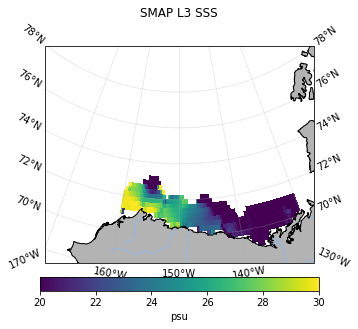

In [7]:
# plot one time
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(projection=map_proj)

tplot = ds_smap_L3.time[0]

sss_L3_img = ax1.pcolormesh(ds_smap_L3.longitude, ds_smap_L3.latitude, ds_smap_L3.sel(time=tplot).smap_sss, 
                        vmin=20, vmax=30,  # Set max and min values for plotting
                        cmap='viridis', shading='auto',   # shading='auto' to avoid warning
                        transform=ccrs.PlateCarree())  # coords are lat,lon but map if NPS 


#  ----- map stuff
ax1.coastlines(color='none')  # coastline
ax1.set_extent([-170, -130,68, 80], crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
ax1.set_title('SMAP L3 SSS')
plt.colorbar(sss_L3_img, ax=ax1, orientation="horizontal", pad=0.05).set_label('psu')
# land color
ax1.add_feature(cartopy.feature.LAND , facecolor=(.7,.7,.7))
ax1.coastlines('10m')
ax1.add_feature(cartopy.feature.RIVERS)
# ticks
gl.ylocator = mticker.FixedLocator([68, 70, 72, 74, 76, 78])
gl.xlocator = mticker.FixedLocator([-170, -160, -150, -140, -130])
gl.top_labels = False
gl.bottom_labels = True



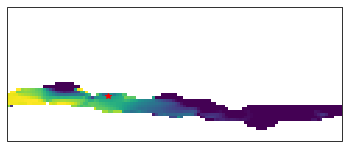

In [39]:
# create a kml file
import simplekml
# directory that will include the kml *and* the pngs that are the source files for the kml
kmldir = '/data2/Dropbox/projects/sassie_kd/google-earth/smap/';

# plot one time
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig = plt.figure()
ax1 = fig.add_subplot(projection=map_proj)

tplot = ds_smap_L3.time[0]

# plot with no transformation
sss_L3_img = ax1.pcolormesh(ds_smap_L3.longitude, ds_smap_L3.latitude, ds_smap_L3.sel(time=tplot).smap_sss, 
                        vmin=20, vmax=30,  # Set max and min values for plotting
                        cmap='viridis', shading='auto')   # shading='auto' to avoid warning
# set extent - needed to get the .png to correctly overlay 
ax1.set_extent([lonrange[0], lonrange[1],latrange[0], latrange[1]], crs=map_proj)

#  ----- no map stuff 

# save figure - need to get rid of bounding boxes and make the background transparent
plt.savefig(kmldir + 'SMAP_L3.png', dpi=400, transparent=True, facecolor=None,
           bbox_inches='tight', pad_inches=0)
 
# initialize the kml with simplekml
kml = simplekml.Kml()
# "overlay" is the (only, in this case) map we'll add to the kml:
overlay = kml.newgroundoverlay(name='overlay')
overlay.icon.href = 'SMAP_L3.png' # this points to the map 
overlay.latlonbox.north = latrange[1]
overlay.latlonbox.south = latrange[0]
overlay.latlonbox.east =  lonrange[1]
overlay.latlonbox.west =  lonrange[0]
# save to the same dir
kml.save(kmldir + "SMAP_L3.kml")

### L2 SMAP SSS

Cload-enabled dataset, but download locally.


In [ ]:
# concept_id = 'C2208418228-POCLOUD' # *** use for near-real-time *** NRT L2B V5.0 JPL
concept_id = 'C2208420167-POCLOUD' # *** use for delayed-mode *** L2B V5.0 JPL => could add a flag to determine if we want NRT or delayed....

granule_url = 'https://cmr.earthdata.nasa.gov/search/granules'
response = requests.get(granule_url,
                       params={
                           'concept_id': concept_id,
                           'temporal': date_range,  
                           'bounding_box': bounding_box,
                           'page_size': 200,
                       },
                       headers={
                           'Accept': 'application/json'
                       }
                      )
print(response.headers['CMR-Hits'])  # number of granules for our time/region

In [42]:
# download the granules
# create a local folder for the data if it doesn't exist
savedir = f'{datadir}smap/L2/'
os.makedirs(savedir, exist_ok=True)

# => need this to authenticate with Drive
from requests.auth import HTTPBasicAuth

granules = response.json()['feed']['entry']
for granule in granules:
    # loop through the granule links to find which one is the actual file: 
    # - identidfied as having 'href' end with '.h5'
    for gl in granule['links']:
        url = gl['href']
        if url.endswith('.h5'):
            # this is the file to download!
            # the actual filename (without the full path) is buried in the granule link 'title' and preceded with the word 'Download ':
            # (could also use   filename = granule['title'] + '.h5' )
            filename = gl['title'].strip('Download ')
            break
    # use 'requests' to get the file:
    #   Password here is the 'Drive API Password' https://podaac-tools.jpl.nasa.gov/drive/
    #   user here is the Earthdata Login username
    r = requests.get(url, auth=HTTPBasicAuth('YOUR_USERNAME', 'YOUR_PASSWORD'))
    outfile = Path(savedir, filename)
    if not outfile.exists():
        print(url, filename)
        with open(outfile, 'wb') as f:
            f.write(r.content)   

# uncomment to see the variable names:
# h5 = h5py.File(outfile, 'r')
# h5.keys() # variable names

https://github.com/podaac/data-subscriber /data1/sassie/satellite/smap/L3/SMAP_L3_SSS_20210905_8DAYS_V5.0.h5


In [43]:
# load each file, select data in our domain, and combine into one array called smap_L2
# this is very klugey! No doubt many cleaner methods exist, but this seems to work OK
# - code modified from https://stackoverflow.com/questions/59288473/how-do-i-combine-multiple-datasets-h5-files-with-different-dimensions-sizes-i

# create a new xarray dataset to store the extracted data along the dimension 'points'
smap_L2 = xr.Dataset(
    dict(
        lon = xr.DataArray([],dims='points'),
        lat = xr.DataArray([],dims='points'),
        sss = xr.DataArray([],dims='points')
    )
)

# the files are listed in "granules" - run through each granule, load, and extract data in our domain
for granule in granules:
    # local file:
    filename = savedir + granule['title']  + '.h5'
    # only try to open the local file if it actually exists:
    if Path(filename).exists():
        # load the file into xarray
        ds = xr.open_mfdataset(filename)
        # extract lon, lat, and sss; reshape so they can later be combined more easily
        lon = np.reshape(ds.lon.values,[1,-1])
        lat = np.reshape(ds.lat.values,[1,-1])
        sss = np.reshape(ds.smap_sss.values,[1,-1])
        # index of points in our domain:
        i = ((lon > lonrange[0]) & (lon < lonrange[1]) & (lat > latrange[0]) & (lat < latrange[1])) 
        sss = sss[i]
        lon = lon[i]
        lat = lat[i]
        # remove nan values
        i = ~np.isnan(sss)
        sss = sss[i]
        lon = lon[i]
        lat = lat[i]
        
        if len(sss)>0:
            print(outfile, 'has', len(sss), 'datapoints in our domain')
            # create a temperary dataset for this file containing
            this_file = xr.Dataset(
                dict(
                    lon = xr.DataArray(lon,dims='points'),
                    lat = xr.DataArray(lat,dims='points'),
                    sss = xr.DataArray(sss,dims='points')
                )
            )
            # add data from this file to 'smap_L2'
            smap_L2 = xr.concat([smap_L2,this_file], dim='points')   


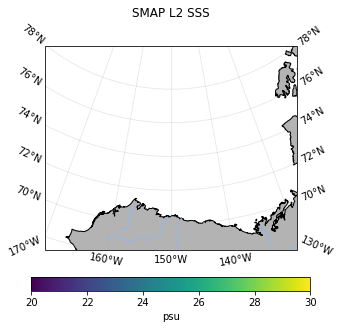

In [44]:
# plot L2 

# set up map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(projection=map_proj)

# scatterplot
sss_L2_img = ax1.scatter(smap_L2['lon'], smap_L2['lat'], c = smap_L2['sss'], 
                        vmin=20, vmax=30,  # Set max and min values for plotting
                        cmap='viridis',   # shading='auto' to avoid warning
                        transform=ccrs.PlateCarree())  # coords are lat,lon but map if NPS 
ax1.set_title('SMAP L2 SSS')
plt.colorbar(sss_L2_img, ax=ax1, orientation="horizontal", pad=0.1).set_label('psu')


#  ----- map stuff
ax1.coastlines(color='none')  # coastline
ax1.set_extent([-170, -130,68, 80], crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
# land color
ax1.add_feature(cartopy.feature.LAND , facecolor=(.7,.7,.7))
ax1.coastlines('10m')
ax1.add_feature(cartopy.feature.RIVERS)
# ticks
gl.ylocator = mticker.FixedLocator([68, 70, 72, 74, 76, 78])
gl.xlocator = mticker.FixedLocator([-170, -160, -150, -140, -130])
gl.top_labels = False
gl.bottom_labels = True


In [ ]:
# plot L2 and L3 SMAP on the same figure

# -- plot properties --
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
crs = ccrs.PlateCarree()
vax = [20, 30] # color axis
# extent = [-170, -130,68, 80]
extent = [-160, -140,70,76]
yticks = [68, 70, 72, 74, 76, 78]
xticks = [-170, -160, -150, -140, -130]
landcolor = (.7,.7,.7)


fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121, projection=map_proj)
sss_L2_img = ax1.scatter(smap_L2['lon'], smap_L2['lat'], c = smap_L2['sss'], 
                        vmin=vax[0], vmax=vax[1],  # Set max and min values for plotting
                        cmap='viridis',   # shading='auto' to avoid warning
                        transform=ccrs.PlateCarree())  # coords are lat,lon but map if NPS 
ax1.set_title('SMAP L2 SSS')
plt.colorbar(sss_L2_img, ax=ax1, orientation="horizontal", pad=0.1).set_label('psu')

# ---------- L3 -------------
ax2 = fig.add_subplot(122, projection=map_proj)
sss_L3_img = ax2.pcolormesh(ds_smap_L3.longitude, ds_smap_L3.latitude, ds_smap_L3.smap_sss, 
                        vmin=vax[0], vmax=vax[1],  # Set max and min values for plotting
                        cmap='viridis', shading='auto',   # shading='auto' to avoid warning
                        transform=ccrs.PlateCarree())  # coords are lat,lon but map if NPS 
ax2.set_title('SMAP L3 SSS')
plt.colorbar(sss_L3_img, ax=ax2, orientation="horizontal", pad=0.1).set_label('psu')


#  ----- map stuff: same for both plots
for ax in [ax1, ax2]:
    ax.coastlines(color='none')  # coastline
    ax.set_extent(extent, crs=crs)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
    # land color
    ax.add_feature(cartopy.feature.LAND , facecolor=landcolor)
    ax.coastlines('10m')
    ax.add_feature(cartopy.feature.RIVERS)
    # ticks
    gl.ylocator = mticker.FixedLocator(yticks)
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.top_labels = False
    gl.bottom_labels = True